# 1. Improt  and Install Dependencies

In [ ]:
!pip install tensorflow opencv-python mediapipe sklearn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import  mediapipe  as mp

# 2. Keypoint using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic Model
mp_drawing  = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def  mediapipe_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #converting color
    image.flags.writeable = False # Image is no longer writeable
    results = model.process(image) #make prediction
    image.flags.writeable = True # Image is now writeable
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) #converting color
    return image,results

# This is optional now,The one being used is the draw_styled_landmarks.

In [4]:
def draw_styled_landmarks(image, result):
    mp_drawing.draw_landmarks(image,result.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(250,250,250), thickness = 2, circle_radius = 2),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness = 1, circle_radius = 1)) # Draw pose conections
    mp_drawing.draw_landmarks(image,result.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS) # Draw left Hand conections
    mp_drawing.draw_landmarks(image,result.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS) # Draw Right Hand conection.

# Optional {For testing the camera and detection mechanisim}

In [59]:
cap  = cv2.VideoCapture(1)
# Accessing mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():
        
        # Read feed
        ret,frame = cap.read()

        # Make detection
        image, results = mediapipe_detection(frame,holistic)
        
        
        # Draw  landmarks
        draw_styled_landmarks(image,results)
        

        cv2.imshow('RSL Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# 3. Extract Keypoint Values

### Optional used in construction of the extraction python statement 

In [6]:
# extraction 
def extract_keypoints(results):
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else  np.zeros(33*4)
    left_hand = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else  np.zeros(21*3)
    right_hand = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else  np.zeros(21*3)

    #concatenate all 
    return np.concatenate([pose,left_hand,right_hand])


# 4. Setup Folders for Collection 

In [7]:
#output will be  arrray containing numerical values for the extracted keypoints
DATA_PATH = os.path.join('MP_Data_phase_2') #exported data

#action we try to detect 

# action that we want to detect Yego 


actions = np.array(['---','yego', 'Neza','Bibi','Urakoze', 'Isibo', 'Umurenge', 'Igihugu', 'Umujyi wa Kigali', 'Kicukiro', 'Nyarugenge'])
no_sequences = 50 # number of videos
start_folder = 1
sequence_length = 30 # frames to be used  

In [8]:
for action in actions:
    for sequence in range(start_folder, start_folder+no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [9]:
#######################################################
#This saves both the extracted features and the video#
#######################################################


# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')


cap = cv2.VideoCapture(1)


# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.4) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            #########################################################
            output_file = os.path.join(DATA_PATH, action, str(sequence), "{}_video_{}.mp4".format(action,sequence))
            out = cv2.VideoWriter(output_file, fourcc, 30.0, (640, 480), isColor=True)
            # Set the bitrate (optional)
            bitrate = 4000000
            out.set(cv2.CAP_PROP_BITRATE, bitrate)
            #########################################################
            
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()
                
                
                ##############################################
                ret, frame = cap.read()

                if ret:
                    # Write the frame into the video file
                    out.write(frame)
                ##############################################    
                

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING  COLLECTION', (15,40),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,255,0), 1, cv2.LINE_AA)
                    cv2.putText(image,'Collection frames for  {} video number {}'.format(action,sequence),(15,20),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('RSL Data Collection Feed', image)
                    cv2.waitKey(2000)
                else:       
                    cv2.putText(image,'Collection frames for  {} video number {}'.format(action,sequence),(15,20),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('RSL Data Collection Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [11]:
label_map = {label:num for  num, label in enumerate(actions)}

In [12]:
label_map

{'---': 0,
 'yego': 1,
 'Neza': 2,
 'Bibi': 3,
 'Urakoze': 4,
 'Isibo': 5,
 'Umurenge': 6,
 'Igihugu': 7,
 'Umujyi wa Kigali': 8,
 'Kicukiro': 9,
 'Nyarugenge': 10}

In [13]:
#pre_processing values
sequences, labels = [], []
for action in actions:
    for sequence in range(1,no_sequences+1):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [14]:
np.array(sequences).shape

(550, 30, 258)

In [15]:
np.array(labels).shape

(550,)

In [16]:
#conversion to get something we can use with

# x representing sequence in numpy_array form 

x = np.array(sequences)


x.shape

(550, 30, 258)

In [17]:
# y representing labels converting it them to  using  to_categorical function 

y = to_categorical(labels).astype(int)

y.shape

(550, 11)

In [18]:
#train and test partition

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)

In [19]:
x_train.shape

(385, 30, 258)

In [20]:
y_test.shape

(165, 11)

# 7. Building and Training LSTM Neural Network
### Be using Keras

In [31]:
#import key dependenceies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from keras import regularizers

In [32]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [33]:

opt = Adam(learning_rate=0.00001)

#setting up a neural network Architecture
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu',kernel_regularizer=regularizers.l2(0.01), input_shape=(30,258)))
model.add(LSTM(128, return_sequences=True, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(LSTM(64, return_sequences=False, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(actions.shape[0], activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

In [34]:
# Compiling the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [35]:
model.fit(x_train, y_train, epochs=150, callbacks=[tb_callback])

Epoch 1/150
13/13 [==============================] - 5s 76ms/step - loss: 9.0507 - categorical_accuracy: 0.1481
Epoch 2/150
13/13 [==============================] - 1s 74ms/step - loss: 9.0216 - categorical_accuracy: 0.1610
Epoch 3/150
13/13 [==============================] - 1s 75ms/step - loss: 8.9963 - categorical_accuracy: 0.1636
Epoch 4/150
13/13 [==============================] - 1s 74ms/step - loss: 8.9725 - categorical_accuracy: 0.1636
Epoch 5/150
13/13 [==============================] - 1s 74ms/step - loss: 8.9495 - categorical_accuracy: 0.1636
Epoch 6/150
13/13 [==============================] - 1s 74ms/step - loss: 8.9278 - categorical_accuracy: 0.1636
Epoch 7/150
13/13 [==============================] - 1s 73ms/step - loss: 8.9066 - categorical_accuracy: 0.1662
Epoch 8/150
13/13 [==============================] - 1s 74ms/step - loss: 8.8858 - categorical_accuracy: 0.1688
Epoch 9/150
13/13 [==============================] - 1s 74ms/step - loss: 8.8647 - categorical_accuracy:

13/13 [==============================] - 1s 75ms/step - loss: 6.3443 - categorical_accuracy: 0.7325
Epoch 74/150
13/13 [==============================] - 1s 74ms/step - loss: 6.2584 - categorical_accuracy: 0.7506
Epoch 75/150
13/13 [==============================] - 1s 74ms/step - loss: 6.1543 - categorical_accuracy: 0.7740
Epoch 76/150
13/13 [==============================] - 1s 73ms/step - loss: 6.0665 - categorical_accuracy: 0.8260
Epoch 77/150
13/13 [==============================] - 1s 74ms/step - loss: 5.9757 - categorical_accuracy: 0.8416
Epoch 78/150
13/13 [==============================] - 1s 74ms/step - loss: 5.8935 - categorical_accuracy: 0.8857
Epoch 79/150
13/13 [==============================] - 1s 73ms/step - loss: 5.8320 - categorical_accuracy: 0.9091
Epoch 80/150
13/13 [==============================] - 1s 75ms/step - loss: 5.7854 - categorical_accuracy: 0.8961
Epoch 81/150
13/13 [==============================] - 1s 74ms/step - loss: 5.7242 - categorical_accuracy: 0.9

13/13 [==============================] - 1s 74ms/step - loss: 4.9151 - categorical_accuracy: 0.9974
Epoch 146/150
13/13 [==============================] - 1s 73ms/step - loss: 4.9067 - categorical_accuracy: 0.9974
Epoch 147/150
13/13 [==============================] - 1s 74ms/step - loss: 4.8985 - categorical_accuracy: 0.9974
Epoch 148/150
13/13 [==============================] - 1s 73ms/step - loss: 4.8905 - categorical_accuracy: 0.9974
Epoch 149/150
13/13 [==============================] - 1s 73ms/step - loss: 4.8822 - categorical_accuracy: 0.9974
Epoch 150/150
13/13 [==============================] - 1s 74ms/step - loss: 4.8742 - categorical_accuracy: 0.9974


In [36]:
model.summary() #get the summary of the training process

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            82688     
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 11)                363       
                                                                 
Total params: 237,515
Trainable params: 237,515
Non-tr

#  8. Make Prediction 

In [37]:
res = model.predict(x_test)

6/6 [==============================] - 1s 29ms/step


In [38]:
actions[np.argmax(res[0])]


'Kicukiro'

In [39]:
actions[np.argmax(y_test[0])]

'Kicukiro'

#  9. Save Weights

In [40]:
# Saving the weights

model.save('RSL Action Detection Script_phase2.h5')

# deleting the model del model
# loading the model model.load_weights('action.h5') after rebuilding and compailing no training 


# 10 . Evaluation Using Confusion Matrix and Accuracy

In [41]:
from  sklearn.metrics import multilabel_confusion_matrix,accuracy_score

In [42]:
yhat = model.predict(x_train)

13/13 [==============================] - 0s 29ms/step


In [43]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [44]:
multilabel_confusion_matrix(ytrue,yhat)

array([[[347,   0],
        [  0,  38]],

       [[348,   0],
        [  0,  37]],

       [[350,   0],
        [  0,  35]],

       [[353,   0],
        [  0,  32]],

       [[352,   0],
        [  0,  33]],

       [[347,   0],
        [  1,  37]],

       [[349,   0],
        [  0,  36]],

       [[351,   0],
        [  0,  34]],

       [[359,   0],
        [  0,  26]],

       [[347,   0],
        [  0,  38]],

       [[346,   1],
        [  0,  38]]], dtype=int64)

In [45]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Obtain the confusion matrix
cm = confusion_matrix(ytrue, yhat)

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



In [46]:
# Define the labels
class_names = actions

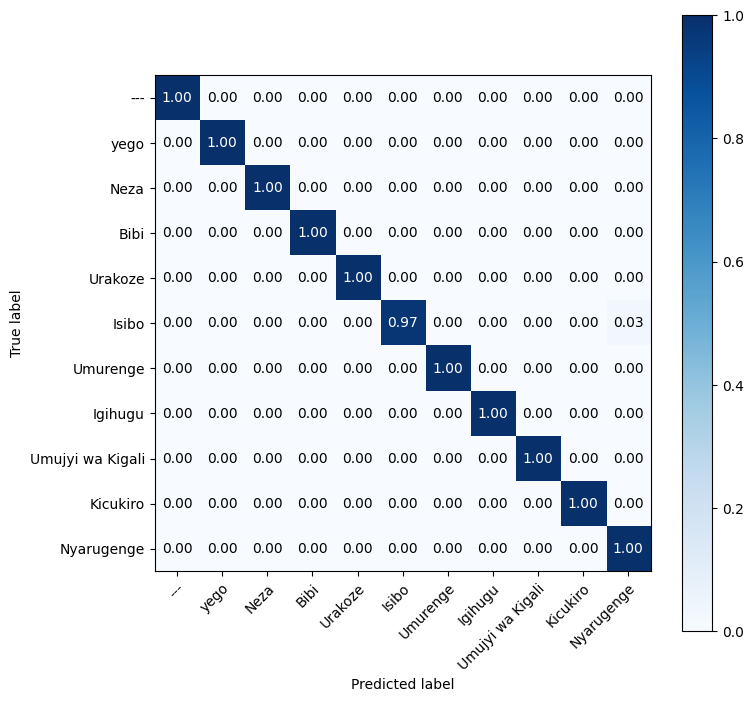

In [47]:
import matplotlib.pyplot as plt

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
ax.set(xticks=np.arange(cm_norm.shape[1]),
       yticks=np.arange(cm_norm.shape[0]),
       xticklabels=class_names,
       yticklabels=class_names,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cm_norm[i, j] > 0.5 else "black")

# Add a colorbar
fig.colorbar(im, ax=ax)
plt.show()


In [48]:
accuracy_score(ytrue,yhat)

0.9974025974025974

In [ ]:
res.size

In [ ]:
res.shape

In [ ]:
np.argmax(res)

# 11.  Test in Real Time

In [49]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.85
init_time = time.time()

cap = cv2.VideoCapture(1)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                       
                    else:
                        sentence.append(actions[np.argmax(res)])
#             else: #clearing
#                 if time.time() - init_time > 15:
#                     print ('its time to clear')
#                     init_time = time.time()
#                     sentence.clear()

            if len(sentence) > 8: 
                sentence = sentence[-8:]

 
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        
        # Show to screen
        cv2.imshow('RSL Translation Feed', image)
        
        # clear the sentence gracefully
        if cv2.waitKey(10) & 0xFF == ord('c'):
            sentence.clear()

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


In [ ]:
cap.release()
cv2.destroyAllWindows()